# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\DW\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX + ASIA_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

# Other Data

In [4]:
neer = read_prices("../../Dymon/Code Data/NEER.csv")

In [5]:
neer.columns = [x[0] for x in neer.columns]

In [6]:
all_neer = neer[[("JBDN"+x+" Index") for x in [y[3:] for y in G10_FX]+["SGD", "THB", "TWD", "KRW", "PHP", "INR", "IDR", "CNY"]]]
all_neer.columns = G10_FX+["USD"+x for x in ["SGD", "THB", "TWD", "KRW", "PHP", "INR", "IDR", "CNH"]]
all_neer_cleaned = all_neer.pipe(fill_date, True).pipe(omit_trailing_na)
# all_neer_cleaned.loc[:,"USDMYR"] = pd.Series(np.nan)

In [7]:
all_neer_cleaned = all_neer_cleaned.rename({"USDEUR":"EURUSD",
                                             "USDAUD":"AUDUSD",
                                             "USDNZD":"NZDUSD",
                                             "USDGBP":"GBPUSD"}, axis=1)

# Data integrity

In [8]:
all_neer.pipe(fill_date).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5665 entries, 2000-01-03 to 2021-09-17
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDAUD  5445 non-null   float64
 1   USDCAD  5445 non-null   float64
 2   USDEUR  5445 non-null   float64
 3   USDGBP  5445 non-null   float64
 4   USDJPY  5445 non-null   float64
 5   USDNZD  5445 non-null   float64
 6   USDSEK  5445 non-null   float64
 7   USDNOK  5445 non-null   float64
 8   USDCHF  5445 non-null   float64
 9   USDSGD  5445 non-null   float64
 10  USDTHB  5445 non-null   float64
 11  USDTWD  5445 non-null   float64
 12  USDKRW  5445 non-null   float64
 13  USDPHP  5445 non-null   float64
 14  USDINR  5445 non-null   float64
 15  USDIDR  5445 non-null   float64
 16  USDCNH  5445 non-null   float64
dtypes: float64(17)
memory usage: 796.6 KB


<AxesSubplot:>

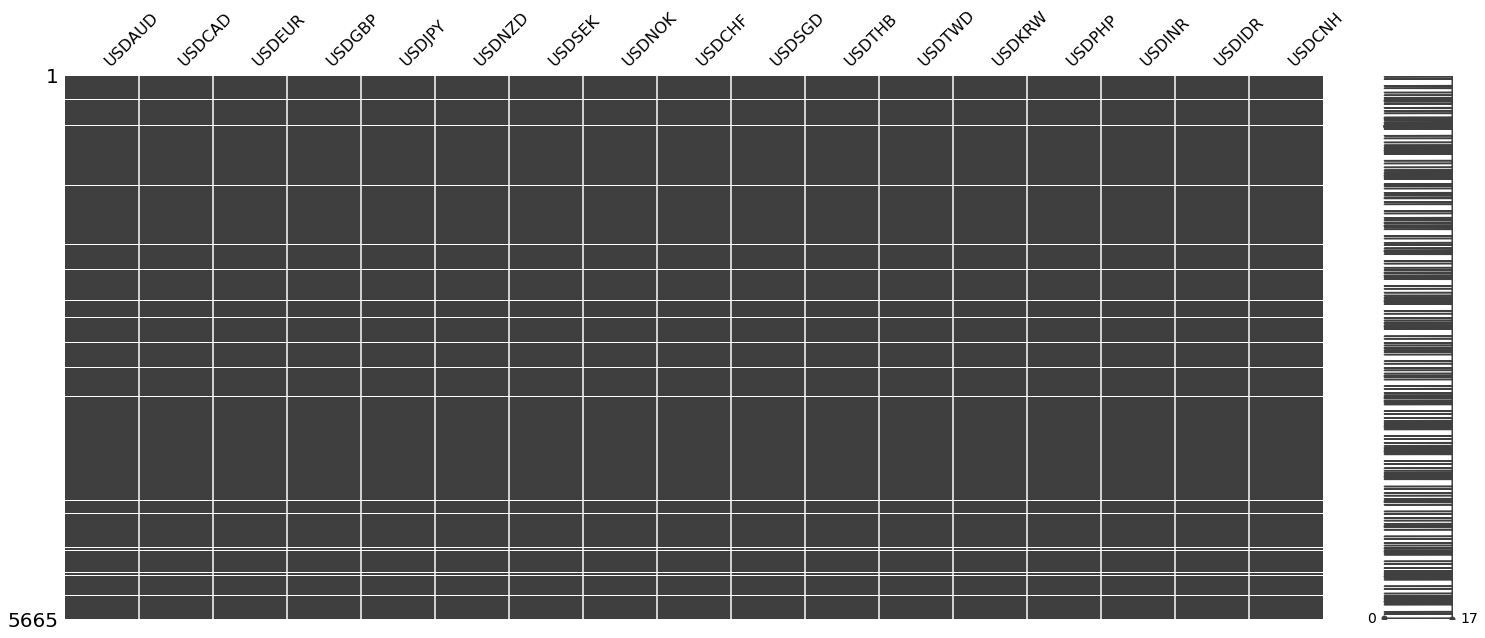

In [9]:
msmx(all_neer.pipe(fill_date))

# Signal 

In [10]:
def band_filter(series):
  return series.applymap(lambda x: -x if abs(x) > 1.5 else 0)

def hold_until_flip(series):
  ser = pd.DataFrame(series)
  ser.columns = ["ccy"]
  ser["shift"] = ser.shift(1)
  ser["sign_change"] = ser.apply(lambda row: 1 if abs(row["ccy"]) > 1.5 else 0, axis=1)
  ser["sign_change"] = ser.apply(lambda row: 1 if row["sign_change"] == 1 else np.nan if pd.isna(row["ccy"]) else 4 if np.sign(row["ccy"]) != np.sign(row["shift"]) else 0 , axis=1)
  ser["signal"] = ser[["ccy"]].pipe(band_filter)
  ser['sign_forward']=ser['sign_change'].replace(0, np.NaN).ffill()
  ser['sign_shift'] = ser['sign_forward'].diff().replace(0, np.NaN)
  ser["signal"] = ser.apply(lambda row: np.nan if pd.isna(row["sign_shift"]) else row["signal"], axis=1).ffill()
  
  return ser["signal"]

In [11]:
sig = all_neer_cleaned.ffill().pct_change().pipe(standardize_series, "returns").pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1

In [12]:
sig = all_neer_cleaned.ffill().pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1

In [13]:
rr = all_neer_cleaned.ffill().pct_change().pipe(zscore, 252*5, 252*3).applymap(lambda x: -1 if x > 1.5 else 1 if x < -1.5 else 0)

In [14]:
rr[rr==0] = np.nan

In [15]:
rr = rr.pipe(fill_date, True)

# Backtest Daily Rebal

In [85]:
daily_bt = Backtest(signal = rr, 
                    asset_returns = total_returns.drop("USDMYR",1), 
                    tcost = abs(total_returns*0), 
                    settings = settings)
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [86]:
get_summary(daily_bt)

Returns   : 0.010619883566137023
Vol       : 0.10562150164494487
SR        : 0.10054660652181041
Max DD    : -47.78

C Returns : 0.005067273610248009
C SR      : 0.04924386410261709
C Max DD  : -38.56

Hit rate  : 0.499
W | N | L : 0.5 | 0.0 | 0.5
W/L Ratio : 1.0


In [87]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDCNH
annualized_return,0.293871,0.492203,-0.078742,-1.433199,1.516029,0.809956,-1.030843,-0.580265,0.049044,-0.569585,-0.371471,0.369661,1.053897,0.032197,0.754997,0.20779,-1.096074
sharpe,0.132315,0.222907,-0.036068,-0.646951,0.674096,0.367644,-0.471966,-0.264116,0.017488,-0.25556,-0.160839,0.164822,0.469934,0.014599,0.331962,0.088144,-0.432347
dollar_sharpe,0.119851,0.207965,-0.041457,-0.668012,0.675982,0.359593,-0.480318,-0.27026,-0.005377,-0.274434,-0.177623,0.153725,0.460989,0.005096,0.320975,0.074293,-0.46464
trade_sharpe,0.132315,0.222907,-0.036068,-0.646951,0.674096,0.367644,-0.471966,-0.264116,0.017488,-0.25556,-0.160839,0.164822,0.469934,0.014599,0.331962,0.088144,-0.432347
long_sharpe,-0.316038,0.198702,0.255175,-0.782291,0.935287,-0.002133,-0.396585,-0.422303,-0.37334,-0.544716,-0.748608,0.111752,0.307293,-0.549789,0.088235,0.038547,-1.002453
short_sharpe,0.623242,0.247107,-0.277211,-0.537263,0.371518,0.781418,-0.565332,-0.125865,0.166696,0.087122,0.566149,0.211723,0.652284,0.459909,0.572274,0.114573,0.446503
sortino,0.096757,0.169673,-0.026162,-0.460887,0.510911,0.283545,-0.352513,-0.191673,0.01644,-0.193996,-0.109657,0.117041,0.3484,0.010512,0.246371,0.057917,-0.224278
max_drawdown,-6.984352,-6.956831,-7.62477,-25.72267,-5.303078,-6.72227,-19.60031,-10.606568,-9.188694,-14.693701,-17.225167,-5.212626,-6.830238,-9.922669,-6.127032,-8.898589,-10.837307
max_drawdown_start,2013-04-11,2005-03-17,2014-05-06,2004-02-17,2004-12-03,2003-07-18,2008-03-19,2004-01-07,2005-02-07,2003-06-30,2007-08-17,2003-08-01,2006-01-31,2007-12-13,2008-10-22,2014-07-09,2012-07-10
max_drawdown_end,2015-11-03,2006-12-04,2016-12-12,2016-06-29,2005-08-30,2005-12-12,2014-06-30,2016-12-28,2007-06-14,2010-12-14,2013-01-02,2004-11-15,2007-07-24,2014-09-01,2011-09-16,2016-12-30,2015-09-07


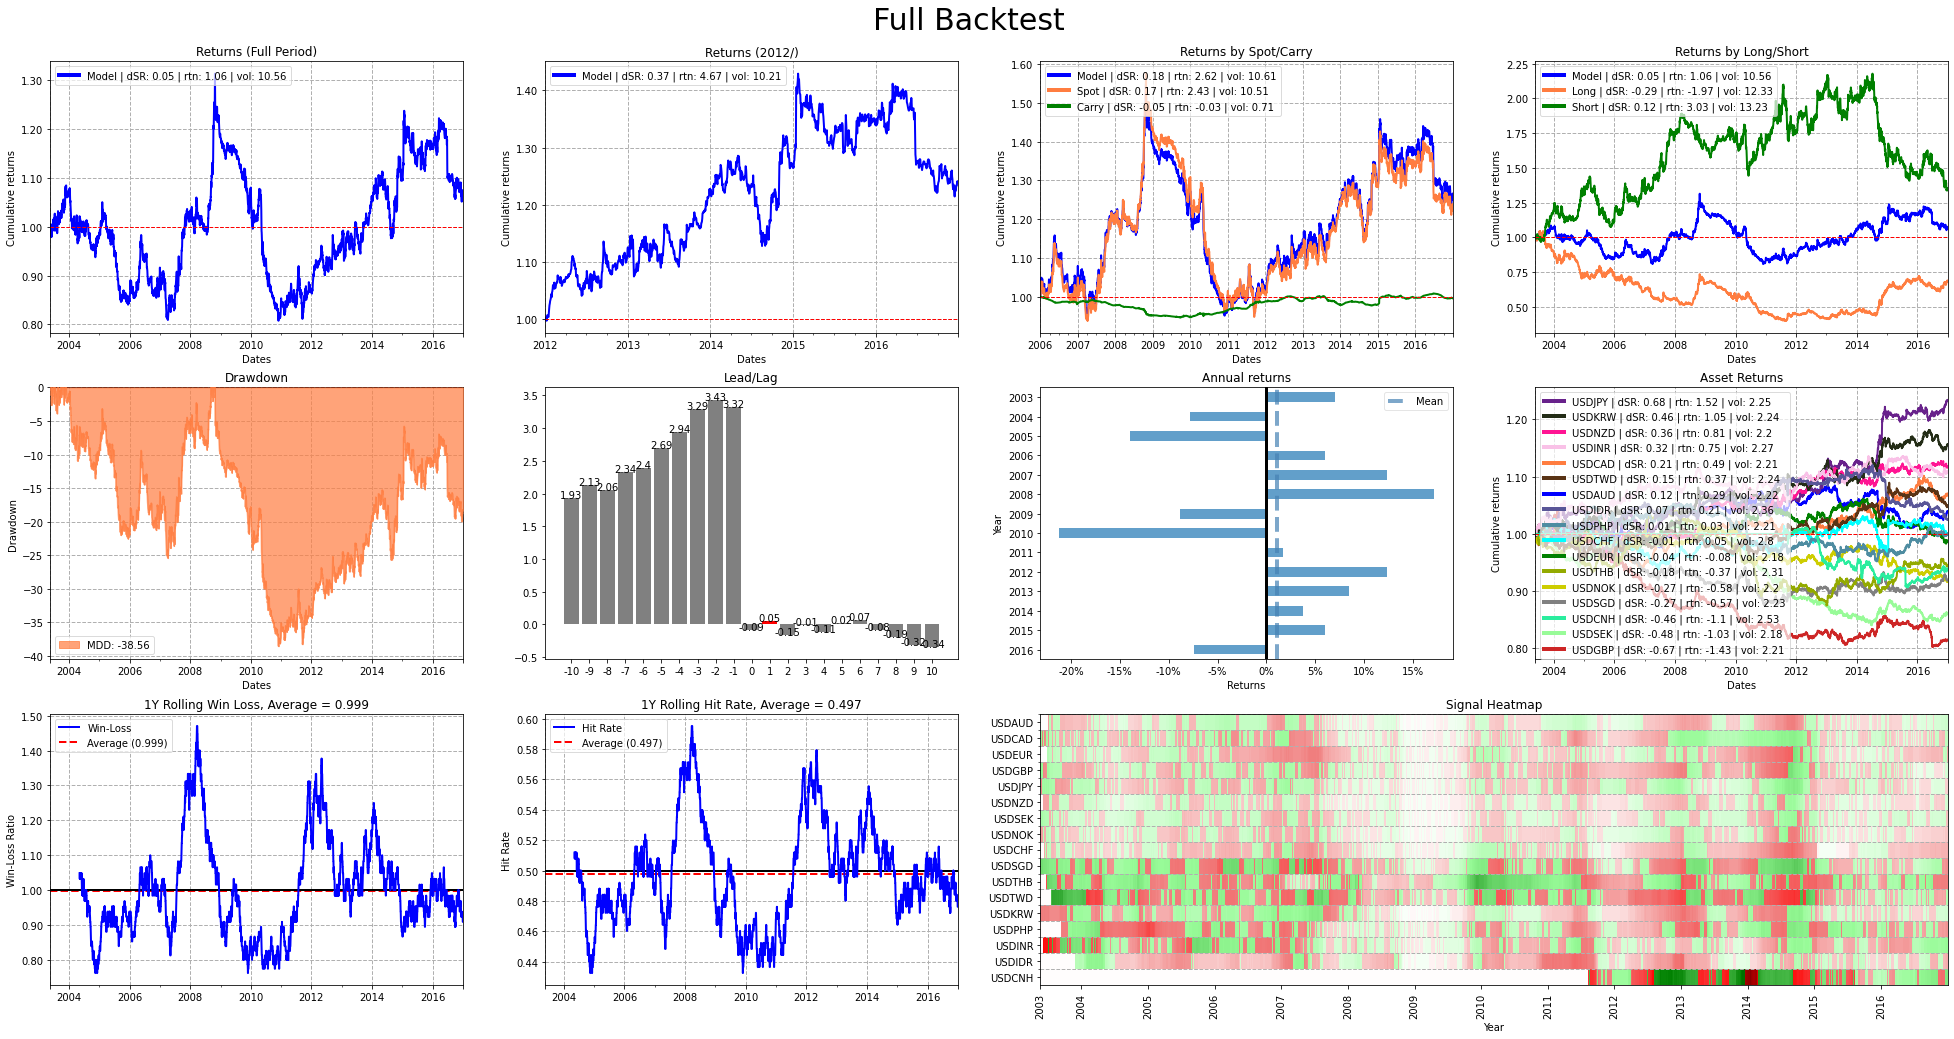

In [88]:
plot_bt(daily_bt)

# Backtest Weekly Rebal

Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


<AxesSubplot:xlabel='Dates', ylabel='Cumulative returns'>

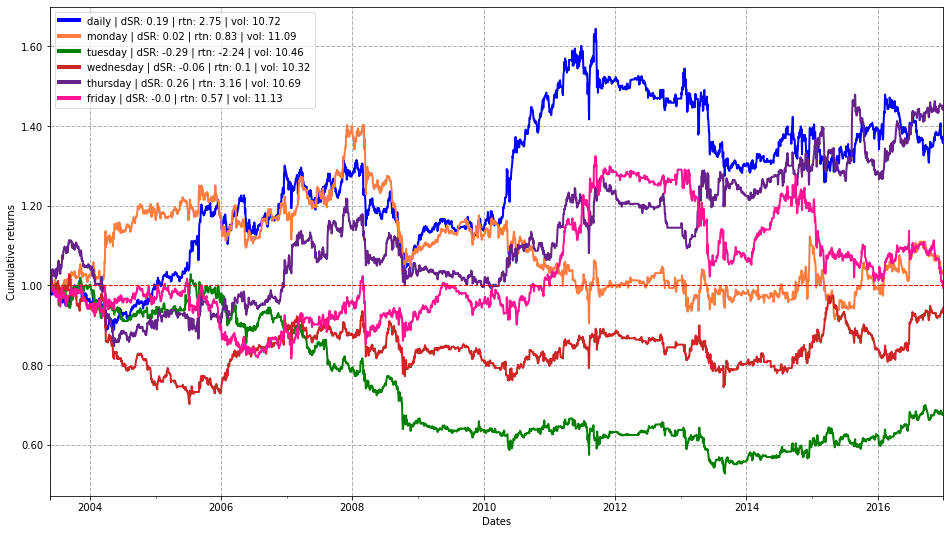

In [19]:
bts = [Backtest(signal = sig, 
             asset_returns = total_returns, 
             tcost = abs(total_returns*0), 
             settings = settings,
             settings_inject = {"rebalance_period":t}) for t in ["monday","tuesday", "wednesday",
                                                                 "thursday", "friday"]]
for bt in bts:
  bt.run()
  
gen_plot_rtn(pd.concat([x.model_rtn.rename(x.rebalance_period) for x in [daily_bt]+bts], axis=1))

In [20]:
pickle.dump(daily_bt, open("../BT/jpm_neer_all_daily.p", "wb"))
daily_bt = pickle.load(open("../BT/jpm_neer_all_daily.p", "rb"))

# pickle.dump(weekly_bt, open("../BT/carry_unwinding_all_weekly.p", "wb"))
# weekly_bt = pickle.load(open("../BT/carry_unwinding_all_weekly.p", "rb"))

# Regime Plot

# Sensitivity Analysis

In [16]:
def signal_generation(lookback):
    sig = all_neer_cleaned.ffill().pct_change().pipe(standardize_series, "returns").pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1
    sig = all_neer_cleaned.ffill().pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1
    rr = all_neer_cleaned.ffill().pct_change().pipe(zscore, 252*5, 252*3).applymap(lambda x: -1 if x > 1.5 else 1 if x < -1.5 else 0)
    rr[rr==0] = np.nan
    rr = rr.pipe(fill_date, True)